Setting up Dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re  # Import re for regex-based tokenization

plt.style.use('ggplot')

# # Define the custom tokenization function
# def simple_tokenize(text):
#     tokens = text.split()  # Basic tokenization by splitting on whitespace
#     return tokens

# Reading data 
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")

# Show the specified index on the 'Reviews' row
print(df['Reviews'].values[0])  

# Print the shape of the dataset.
print(df.shape)

# Display the first few rows of the DataFrame
df = df.head(500)


I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!
(413840, 6)


QUICK EDA

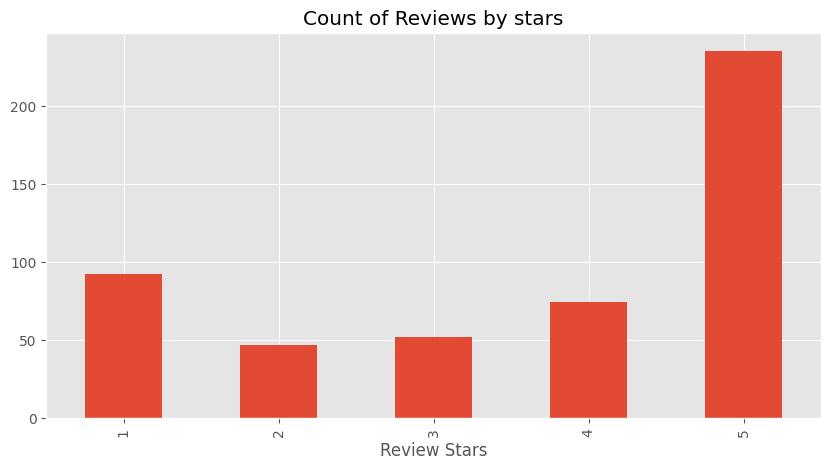

In [5]:
# Quick EDA: Plot the count of reviews by stars
ax = df['Rating'].value_counts().sort_index().plot(
    kind='bar', 
    title='Count of Reviews by stars',
    figsize=(10, 5)
)
ax.set_xlabel('Review Stars')
plt.show()

BASIC NLTK TOKENIZATION

In [6]:
# Basic NLTK Tokenization
example = df['Reviews'][10]
tokens = nltk.word_tokenize(example)  # Tokenize the 'example' variable
print(tokens)
tokens[:10] #first 10 words
tagged= nltk.pos_tag(tokens)
tagged[:10]
#putting them into entities

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


['My', 'fiance', 'had', 'this', 'phone', 'previously', ',', 'but', 'caused', 'many', 'problems', '.', 'So', ',', 'of', 'course', ',', 'we', 'decided', 'to', 'browse', 'amazon', 'for', 'a', 'replacement', 'til', "'", 'our', 'contract', 'is', 'up', '!', '&', 'so', 'far', 'so', 'good', '!']
(S
  My/PRP$
  fiance/NN
  had/VBD
  this/DT
  phone/NN
  previously/RB
  ,/,
  but/CC
  caused/VBD
  many/JJ
  problems/NNS
  ./.
  So/RB
  ,/,
  of/IN
  course/NN
  ,/,
  we/PRP
  decided/VBD
  to/TO
  browse/VB
  amazon/NN
  for/IN
  a/DT
  replacement/NN
  til/NN
  '/''
  our/PRP$
  contract/NN
  is/VBZ
  up/RP
  !/.
  &/CC
  so/RB
  far/RB
  so/RB
  good/JJ
  !/.)


In [7]:
# nltk.download()

VADERS MODEL
- Uses a "cluster of words" approach
- Stop words are removed e.g. and, or
- Each word is combined to a total score

In [26]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Ensure 'Reviews' column is string type and handle missing values
df['Reviews'] = df['Reviews'].astype(str)  # Convert all entries to string

# Dictionary to store results
results = []

# Run polarity score on the entire dataset
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Reviews']
    name = row['Brand Name']
    
    if isinstance(text, str):  # Check if text is a string
        polarity_scores = sia.polarity_scores(text)
        polarity_scores['Brand Name'] = name  # Add 'Brand Name' to the results
        results.append(polarity_scores)
    else:
        results.append({"Brand Name": name, "error": "Invalid text"})

# # Convert results into a DataFrame
# vaders = pd.DataFrame(results)

# # Merge the results with the original DataFrame
# vaders = vaders.merge(df, how='left', on='Brand Name')

# # Display the first few rows of the merged DataFrame
# vaders.head()


  0%|          | 0/500 [00:00<?, ?it/s]

In [72]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={"index": "Id"})
vaders = vaders.merge(df, how="left")

KeyError: 'Brand Name'

In [68]:
#No we have sentiment score and metadata
vaders.head()

,Rating,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Product Name,Brand Name,Price,Reviews,Review Votes
0,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,I feel so LUCKY to have found this used (phone...,1.0
1,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,Very pleased,0.0
2,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,I originally was using the Samsung S2 Galaxy f...,0.0
3,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,This is a great product it came after two days...,0.0
4,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,These guys are the best! I had a little situat...,2.0


PLOT VADERS RESULTS
- bar plot of the compound of ratings

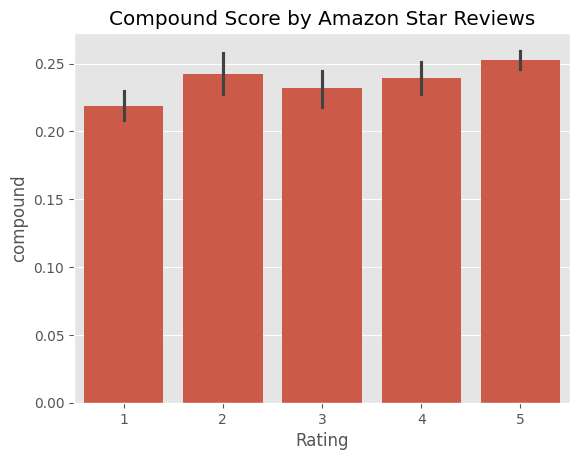

In [10]:
ax = sns.barplot(data = vaders, x = 'Rating', y='compound')
ax.set_title('Compound Score by Amazon Star Reviews')
plt.show()

POS, Neg, Neu Scores of the star Ratings

Observation and Assumptions respectively
- The Plots look similar to one another.

- Vader tends to pick up on a lot of cluster words and may not be finely tuned to nuances
- There are many nuances of specific texts leading to similar sentiment scores across different ratings.

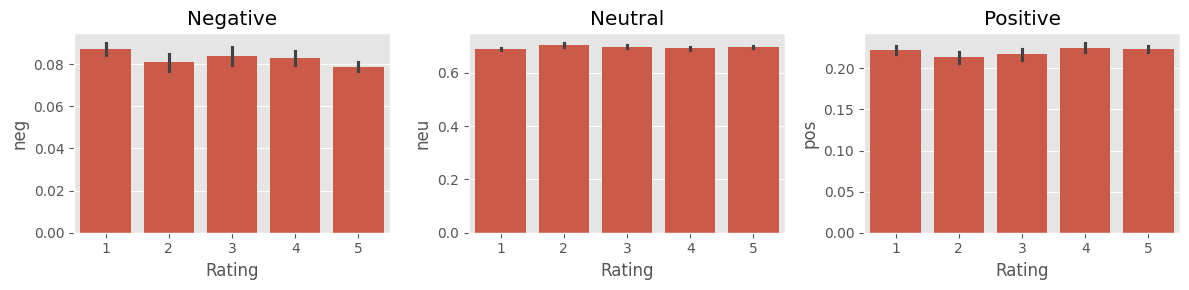

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data = vaders, x = 'Rating', y='neg', ax=axs[0])
sns.barplot(data = vaders, x = 'Rating', y='neu', ax=axs[1])
sns.barplot(data = vaders, x = 'Rating', y='pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.tight_layout()
plt.show()

ROBERTA PRETRAINED MODEL
- Uses a model trained of a large corpus of data
- Transformer model accounts for the words but also the context related to other words
- Applying the trained weights to the dataset

In [13]:

#ROBERTA MODEL
import tf_keras as keras
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
from scipy.special import softmax

#Specific model trained
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = RobertaTokenizer.from_pretrained(MODEL)
model = RobertaForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# sia.polarity_scores(example)

In [15]:
# encoded text
import numpy as np
encoded_text = tokenizer(example, return_tensors = "pt")
output = model(**encoded_text) #tensor with our results
print(output) 
scores = output[0][0].detach().numpy() #convert to numpy array
scores = softmax(scores) #apply softmax
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)


SequenceClassifierOutput(loss=None, logits=tensor([[-0.7586,  0.0125,  0.9647]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
{'roberta_neg': 0.11408854, 'roberta_neu': 0.24666648, 'roberta_pos': 0.6392449}


In [18]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = "pt")
    output = model(**encoded_text) #tensor with our results
    print(output) 
    scores = output[0][0].detach().numpy() #convert to numpy array
    scores = softmax(scores) #apply softmax
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [43]:
results = {}

# Run polarity score on the entire dataset
for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
                text = row['Reviews']
                rate = row['Rating']
                vader_result = sia.polarity_scores(text)
                #rename
                vader_result_rename = {}
                for key, value in vader_result.items():
                        vader_result_rename[f"vader_{key}"] = value
                        
                roberta_result = polarity_scores_roberta(text)
                both= {**vader_result_rename,  **roberta_result}
                results[rate] = both
        except RuntimeError:
                print(f"Broke for the rating: {rate}")

  0%|          | 0/500 [00:00<?, ?it/s]

SequenceClassifierOutput(loss=None, logits=tensor([[-1.9108, -0.5009,  3.0563]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-2.2665, -0.7459,  3.8441]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-2.6510,  0.1087,  3.1351]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-2.0012, -0.7938,  3.6114]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[-0.8940, -0.0059,  1.2029]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[ 2.2062, -0.0542, -2.2693]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
SequenceClassifierOutput(loss=None, logits=tensor([[ 0.9189,  0.2051, -1.2075]], grad_fn=<AddmmBackward0>), hidden_states=None, at

In [57]:
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index()



In [52]:
results_df.head()

,index,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,5,0.005,0.753,0.242,0.9943,0.004565,0.031279,0.964155
1,4,0.000,0.721,0.279,0.4767,0.087215,0.847931,0.064854
2,1,0.196,0.661,0.143,-0.1815,0.945584,0.048659,0.005757
3,2,0.186,0.714,0.100,-0.1611,0.965136,0.031254,0.003609
4,3,0.056,0.819,0.125,0.7553,0.490710,0.341235,0.168055
